In [1]:
import sys
import os
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 96

from sklearn.utils import Bunch
import scipy.stats
import scipy.special

sys.path.insert(0, os.path.abspath(".."))

import seldon.ambiguity.posterior as posterior
from seldon.inference import BayesianInference, Posterior
from seldon.utils.binning import bin_values

In [2]:
def out_path(*parts) -> Path:
    p = Path("out", *parts)
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

In [3]:
def to_filename(ns: np.ndarray, file_extension: str = "pdf") -> str:
    if len(ns.shape) > 1:
        ns, *_ = ns
    ns = ns.tolist()
    return f"example_{'-'.join(map(str, ns))}.{file_extension}"

In [4]:
def simulation_plot(
    posterior_object: Posterior,
    ax: mpl.axes.Axes,
    sample_size: int = 100_000,
    simulation_size: int = 100,
    bins: int = 256
):
    
    bins_results = list()
    amb_values = list()
    
    for _ in range(simulation_size):
        amb = posterior_object.sample(repeats=sample_size)
        bins_results.append(bin_values(amb, bins=bins))
        amb_values.append(amb)

    def to_densities(bin_res):
        return (
            1 / bin_res.bin_width * bin_res.counts / bin_res.counts.sum()
        )
    
    all_densities = np.vstack([to_densities(bins_res) for bins_res in bins_results])
    
    q25, q50, q75 = np.quantile(all_densities, q=[0.25, 0.5, 0.75], axis=0)
    xticks = np.linspace(0, 1, 21)
    ax.plot(bins_results[0].bin_centers, q50, color="red")
    ax.fill_between(bins_results[0].bin_centers, q25, q75, color="red", alpha=0.3)
    ax.set_xlim(0, 1+1e-2)
    ax.set_xticks(xticks[::2])
    ax.set_xticks(xticks[1::2], minor=True)
    ax.grid(axis="x", which="major", linewidth=1)
    ax.grid(axis="x", which="minor", linewidth=1)
    ax.grid(axis="y")
    ax.set_xlabel("value")
    ax.set_ylabel("density")

    if isinstance(posterior_object, posterior.AmbiguityPosterior):
        ax.set_title("Old Ambiguity Measure")
    if isinstance(posterior_object, posterior.NewAmbiguityPosterior):
        ax.set_title("New Ambiguity Measure")
    if isinstance(posterior_object, posterior.ModifiedNewAmbiguityPosterior):
        ax.set_title("New Ambiguity Measure (Modified)")
    
    return ax, Bunch(
        samples=np.vstack(amb_values),
        median_counts=q50,
        bin_centers=bins_results[0].bin_centers
    )

In [5]:
def annotated_simulation_plot(posterior_object: Posterior, ax: mpl.axes.Axes, **kwargs):
    
    ax, res = simulation_plot(posterior_object=posterior_object, ax=ax, **kwargs)
    
    mu = posterior_object.mean()
    sigma = posterior_object.std()
    lower, upper = np.clip(mu + np.array([-1, 1]) * sigma, 0, 1)
    idx_lower, idx_mean, idx_upper = (
        np.abs(res.bin_centers.reshape(1, -1) - np.array([lower, mu, upper]).reshape(-1, 1))
        .argmin(axis=-1)
    )
    bin_indices_selected = np.arange(idx_lower, idx_upper + 1)
    median_counts_selected = res.median_counts[bin_indices_selected]

    predicate = (
        "exact" if any([
            isinstance(posterior_object, cls)
            for cls in [posterior.NewAmbiguityPosterior, posterior.ModifiedNewAmbiguityPosterior]
        ])
        else "approx."
    )
    
    ax.fill_between(
        res.bin_centers[bin_indices_selected],
        np.zeros_like(median_counts_selected),
        median_counts_selected,
        alpha=0.3,
        label=f"{predicate} std"
    )
    ax.vlines(
        x=res.bin_centers[idx_mean],
        ymin=0,
        ymax=res.median_counts[idx_mean],
        color="black",
        linestyle="--",
        label=f"{predicate} mean"
    )
    ax.legend()

    return ax, res

In [6]:
ns = np.array([10, 1, 1])
#ns = np.array([5, 0, 0])
#ns = np.array([10, 0, 0])
#ns = np.array([30, 0, 0])
#ns = np.array([0, 0, 7])

#ns = np.array([0, 0, 0, 0, 0])

In [7]:
# Choice of prior
beta: float = 1

kwargs = dict(
    sample_size=100_000,
    simulation_size=100
)

## An analytical expression in the case of $C+1=3$

In [8]:
def compute_xi(ambs: np.ndarray, us: np.ndarray, modified: bool = False) -> np.ndarray:
    # ambs: (M,)
    # us: (N,)
    dd = (1 - ambs.reshape(-1, 1)) / (1 - us)
    if not modified:
        dd = 2 * dd - 1
    # dd: (M, N)
    return np.permute_dims(1/2 * (
        # (M, N, 2)
        1 + np.array([1, -1]) * np.expand_dims(np.sqrt(np.maximum(0, dd)), axis=-1)
    ), (2, 0, 1))


def compute_dxi_da(ambs: np.ndarray, us: np.ndarray, modified: bool = False) -> np.ndarray:
    # ambs: (M,)
    # us: (N,)
    denom_squared = (1 - ambs).reshape(-1, 1) * (1 - us)
    factor = 1/4
    if not modified:
        denom_squared = np.maximum(1e-7, denom_squared + (
            (us - ambs.reshape(-1, 1)) * (1 - us)
        ))
        factor *= 2
    return np.permute_dims(factor * np.array([-1, 1]) * np.expand_dims(1 / np.sqrt(denom_squared), axis=-1), (2, 0, 1))

In [9]:
def amb_density(ambs: np.ndarray, alphas: list[float], modified: bool = False):
    # ambs: (M,)
    g_ambs = np.maximum(0, 2 * ambs  - 1)
    
    # Concentration parameters
    assert len(alphas) == 3
    a_a, a_b, a_cs = alphas
    
    # Define grid over u
    us_grid = np.linspace(0, 1, 10001)
    us_left = us_grid[:-1]
    us_right = us_grid[1:]
    us = (us_left + us_right) / 2
    du = us_right - us_left
    is_valid = us_right <= ambs.reshape(-1, 1)
    if not modified:
        is_valid = np.logical_and(
            is_valid,
            us_left >= g_ambs.reshape(-1, 1)
        )
    
    # us, du: (N,)
    # is_valid: (M, N)
    
    # Compute xi± and its derivatives with respect to ambiguity value
    xi_plus, xi_minus = compute_xi(ambs, us, modified=modified)
    dxi_plus, *_ = compute_dxi_da(ambs, us, modified=modified)
    # xi_{plus,minus}: (M, N)
    # dxi_plus: (M, N)
    
    beta_pdf = scipy.stats.beta.pdf
    # beta_cdf = scipy.stats.beta.cdf
    
    # pdf_a = beta_pdf(ambs, a=a_cs, b=a_a+a_b)
    pdf_u = beta_pdf(us, a=a_cs, b=a_a+a_b)
    # cdf_plus = beta_cdf(xi_plus, a=a_a, b=a_b)
    # cdf_minus = beta_cdf(xi_minus, a=a_a, b=a_b)
    pdf_plus = beta_pdf(xi_plus, a=a_a, b=a_b)
    pdf_minus = beta_pdf(xi_minus, a=a_a, b=a_b)
    # pdf_a: (M,), pdf_u: (N,)
    # cdf_{plus,minus}: (M, N)
    # pdf_{plus,minus}: (M, N)
    
    # Stitch it together
    integral = -np.sum(
        pdf_u * du
        * is_valid * dxi_plus * (
            pdf_plus + pdf_minus
        ),
        axis=-1
    )
        
    # integral: (M,)
        
    return integral

In [10]:
modified: bool = False

ambs = np.linspace(0, 1, 101)[1:-1]
ambs_grid = np.linspace(0, 1, 101)
ambs_left = ambs_grid[:-1]
ambs_right = ambs_grid[1:]
ambs = (ambs_left + ambs_right) / 2
dambs = ambs_right - ambs_left
density = amb_density(ambs, alphas=(ns + beta * np.ones_like(ns)).tolist(), modified=modified)

unit_mass = np.sum(
    dambs * density
)

exp_amb = np.sum(dambs * ambs * density)
idx_closest_on_grid = np.abs(ambs - exp_amb).argmin()
exp_corresponding_density = density[idx_closest_on_grid]

unit_mass

np.float64(0.999483178105424)

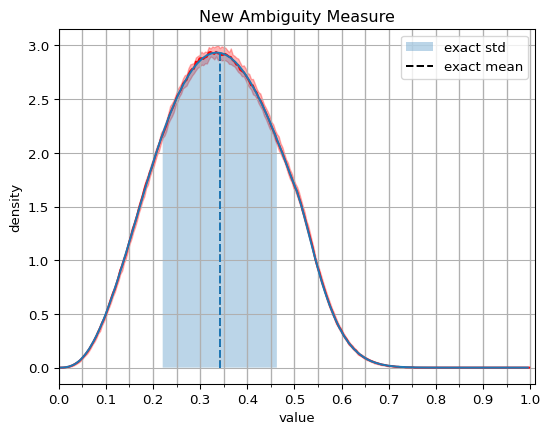

In [11]:
inference_object = (
    BayesianInference
    .specify(
        posterior.ModifiedNewAmbiguityPosterior
        if modified
        else posterior.NewAmbiguityPosterior
    )
)(beta=beta).fit(ns)

fig, ax = plt.subplots()
_, res = annotated_simulation_plot(inference_object.posterior, ax=ax, **kwargs)
ax.plot(ambs, density)
ax.vlines(x=exp_amb, ymin=0, ymax=exp_corresponding_density, linestyles="--")
plt.show()